In [1]:
'''
References: https://pytorch3d.org/tutorials/fit_simple_neural_radiance_field
https://github.com/yenchenlin/nerf-pytorch
'''
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import mlflow
import plotly.express as px
from src.utils import visualize_plotly
import pytorch3d
from PIL import Image
from tqdm import tqdm
from src.get_bottles import get_data, MyCam
from src.Network import NeuralRadianceField_torch
from src.ray_utils import get_rays_all_files, ray_march, get_pts_from_ray_batch, hier_sample

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("All tensors by default will be created as Float and on cuda device, most of these tensors will be created in render only.")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print('CPU being used, check once!!' )
    device = torch.device("cpu")

All tensors by default will be created as Float and on cuda device, most of these tensors will be created in render only.


In [2]:
display_figs = True
if display_figs:   
    from IPython import display

In [3]:
viz_freq = 500
viz_train = False
val_freq = 100

## Args
args = {}
args['zfar'] = 6.0
args['znear'] = 0.5

args['dataset'] = 'bottles' # [bottles, cow]
args['image_size'] = 800
resize_ratio = args['image_size']/800
args['train_size'] = 100    # max (200 - val_size)
args['val_size'] = 10
args['white_bkg'] = True

args['learning_rate'] = 5e-4
args['num_iterations'] = 20000
args['accum_iter'] = 1
# args['num_iterations'] after counting gradient accumulation
args['num_iterations'] *= args['accum_iter']

args['n_rays_per_batch'] = 4096 // args['accum_iter']
args['n_pts_per_ray'] = 127
#args['n_heir_pts_per_ray'] = 128
args['stratified_sampling'] = True

args['num_layers'] = 6
skip_attach_after = 4
args['skips']=[skip_attach_after-1] if skip_attach_after is not None else []

args['coarse_fn_path'] = None #'models/bottles_100000_800_180_8_1.tar'
args['checkpoint'] = 'models/_bottles_10000_800_100_6_1.tar' #'models/fine_trained_bottles_200000_800_180_8_2.tar'
#_prefix = '' if args['coarse_fn_path'] is None else 'fine_trained'
_prefix = ''

if args['coarse_fn_path'] is not None:
    args['init_fine_fn'] = True # Only useful if 'checkpoint' is not mentioned else checkpoint overrides it.

args['model_save_path'] = f"models/{_prefix}_{args['dataset']}_{args['num_iterations']}_{args['image_size']}_{args['train_size']}_{args['num_layers']}_{args['accum_iter']}.tar"
args['eval_up_model_save_path'] = f"models/eval_up_{_prefix}_{args['dataset']}_{args['num_iterations']}_{args['image_size']}_{args['train_size']}_{args['num_layers']}_{args['accum_iter']}.tar"
args['n_harmonic_functions_pos'] = 10
args['n_harmonic_functions_dir'] = 4
n_harmonic_functions = 10

print('model_path: ', args['model_save_path'])

log_mlflow = True
if log_mlflow:
    args['description'] = "Without positional encoding"
    try:
        mlflow.end_run()
    except Exception as e:
        pass
    mlflow.set_experiment('Default')
    mlflow.start_run()
    print("runid: ", mlflow.active_run().info.run_id)

    mlflow.log_params(args)
else:
    print("======NO MLFLOW========")

model_path:  models/_bottles_20000_800_100_6_1.tar
runid:  5018a129b59f4418b9d6563eb1ae481d


In [4]:
# Get Data: Numpy Land
def split(tensor, tsize):
    return tensor[:-tsize], tensor[-tsize:]

def split_cameras(cameras, tsize):
    args = cameras.get()
    c2ws_split = split(args[-1],tsize)
    return MyCam(*args[:-1], c2ws_split[0]), MyCam(*args[:-1], c2ws_split[1])

files, cameras, images, silhouettes = get_data(train_not_test = True, num_files = args['train_size'] + args['val_size'], resize_ratio = resize_ratio)

train_files, val_files = split(files, args['val_size'])
train_images, val_images = split(images, args['val_size'])
train_sil, val_sil = split(silhouettes, args['val_size'])
train_cameras, val_cameras = split_cameras(cameras, args['val_size'])

In [5]:
train_rays_rgb = get_rays_all_files(train_cameras, train_images, shuffle = True) # [N*H*W, 3(ro+rd+rgb), 3]
val_rays_rgb = get_rays_all_files(val_cameras, val_images, shuffle = False) # Unshuffled, will be used for generating full size render

In [6]:
# # don't try with shuffled
# rays_rgb = val_img_rays_rgb.reshape((-1, 100*100, 3, 3)) # [N, W*H, 3, 3]
# rd_0 = rays_rgb[0,4947:4951,1,:]
# ros = rays_rgb[:,0,0,:]

# visualize_plotly(np.concatenate([np.zeros(3).reshape((1,-1))] + [(rd_0*t + ros[0]) for t in list(np.linspace(0,3,1000))], 0))

In [7]:
## Torch land start, notice rays are not put on the gpu, sometimes they can be huge in size
train_rays_rgb = torch.tensor(train_rays_rgb, device='cpu') # Have to explicitly put 'cpu', as new tensors by default are on cuda
val_rays_rgb = torch.tensor(val_rays_rgb, device='cpu')

In [8]:
# Render works in torch land, i.e. everything is in torch
def render_coarse(ray_batch, nerf_fun):
    # Create needed variables
    rays_o, rays_d = ray_batch
    viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True) # [N_rays, 3]
    near, far = args['znear'] * torch.ones_like(rays_d[...,:1]), args['zfar'] * torch.ones_like(rays_d[...,:1])

    pts, z_vals = get_pts_from_ray_batch(rays_o, rays_d, near, far, args['n_pts_per_ray'], args['stratified_sampling']) # [N_rays, N_samples, 3]
    
    # Needed to allow concatenating with the features in the model
    viewdirs = viewdirs[:,None].expand(pts.shape)   # [N_rays, N_samples, 3]
    
    c_sigma  = nerf_fun(torch.cat([pts, viewdirs], -1)) # [N_rays, N_samples, 4]

    rgb_map, weights, depth_map = ray_march(c_sigma, z_vals, rays_d, white_bkgd = args['white_bkg'])

    return rgb_map, weights, depth_map, z_vals

def render_fine(ray_batch, z_vals, nerf_fun):
    # Create needed variables
    rays_o, rays_d = ray_batch
    viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True) # [N_rays, 3]
    
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]
    
    # Needed to allow concatenating with the features in the model
    viewdirs = viewdirs[:,None].expand(pts.shape)   # [N_rays, N_samples, 3]
    
    c_sigma  = nerf_fun(torch.cat([pts, viewdirs], -1)) # [N_rays, N_samples, 4]

    rgb_map, weights, depth_map = ray_march(c_sigma, z_vals, rays_d, white_bkgd = args['white_bkg'])

    return rgb_map, weights, depth_map, z_vals

def render(ray_batch, nerf_fun, coarse_nerf_fun):
    if coarse_nerf_fun is None:
        rgb_map, weights, depth_map, _ = render_coarse(ray_batch, nerf_fun)
        return rgb_map, weights, depth_map
    else:
        with torch.no_grad():
            _, weights, _, z_vals = render_coarse(ray_batch, coarse_nerf_fun)
            z_samples = hier_sample(z_vals, weights, args['n_heir_pts_per_ray'])
        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)  # [N_rays, n_pts + n_hier_pts]
        rgb_map, weights, depth_map, _ = render_fine(ray_batch, z_vals, nerf_fun)
        return rgb_map, weights, depth_map
    

def chunk_render(rays, nerf_fun):
    chunk=args['n_rays_per_batch']
    outs = [[] for _ in range(3)]
    for idx in range(0, rays.shape[0], chunk):
        print("chunk idx: ", idx)
        o = render(rays[idx:idx+chunk], nerf_fun)
        for i,val in enumerate(o):
            outs[i].append(val)
    return [torch.cat(m, 0) for m in outs]

In [9]:
img2mse = lambda x, y : torch.mean((x - y) ** 2)
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))

def log_stuff(loss, psnr, hist_col, hist_psnr, prefix, iter):
    # Log the loss history.
    hist_col.append(float(loss))
    hist_psnr.append(float(psnr))
    if log_mlflow:
        mlflow.log_metrics({prefix + ' loss color': float(loss), prefix + ' psnr': float(psnr)}, step=iter//args['accum_iter'])

def get_loss_psnr_from_batch(batch, nerf_fun, coarse_nerf_fun, render_fn, val):
    batch = torch.transpose(batch, 0, 1)	# [2+1, B, 3]
    batch_rays, target_s = batch[:2], batch[2]

    was_not_on_cuda = not batch_rays.is_cuda

    if was_not_on_cuda:
        batch_rays = batch_rays.to(device)
        target_s = target_s.to(device)

    if not val:
        rgb_map, weights, depth_map = render_fn(batch_rays, nerf_fun, coarse_nerf_fun)
    else:
        with torch.no_grad():
            rgb_map, weights, depth_map = render_fn(batch_rays, nerf_fun, coarse_nerf_fun)

    loss = img2mse(rgb_map, target_s)
    psnr = mse2psnr(loss)

    if was_not_on_cuda:
        batch_rays = batch_rays.to('cpu')
        target_s = target_s.to('cpu')

    return loss, psnr, rgb_map, target_s

def get_loss_psnr(rays_rgb, nerf_fun, coarse_nerf_fun, val, i_batch = None):
    if i_batch is not None:
        batch = rays_rgb[i_batch:i_batch+args['n_rays_per_batch']] # [B, 2+1, 3]
        i_batch += args['n_rays_per_batch']
        if i_batch >= rays_rgb.shape[0]:
            # Shuffle data after an epoch as in implementation!
            rand_idx = torch.randperm(rays_rgb.shape[0])
            rays_rgb = rays_rgb[rand_idx]
            i_batch = 0
    else:
        batch = rays_rgb[torch.randperm(rays_rgb.shape[0])[:args['n_rays_per_batch']]]

    loss, psnr, rgb_map, target_s = get_loss_psnr_from_batch(batch, nerf_fun, coarse_nerf_fun, render, val)

    return loss, psnr, rays_rgb, i_batch, rgb_map, target_s

def get_item_from_unshuffled(rays, i):
    l, u = i*(args['image_size']*args['image_size']), (i+1)*(args['image_size']*args['image_size'])
    return rays[l:u, :, :]

def render_full_size_on_cpu(rays_rgb, nerf_fun, coarse_nerf_fun):
    i_batch = 0
    r_maps, tars = [], []
    while True:
        _, _, rays_rgb, i_batch, rgb_map, target_s = get_loss_psnr(rays_rgb, nerf_fun, coarse_nerf_fun, True, i_batch)
        r_maps.append(rgb_map.to('cpu'))
        tars.append(target_s.to('cpu'))
        if i_batch == 0:
            break
    return torch.cat(r_maps, 0), torch.cat(tars, 0)

In [10]:
    
def show_full_render(
    nerf_fun, coarse_nerf_fun, device, rays_rgb,
    tcolor, tpsnr, vcolor, vpsnr,
):
    """
    This is a helper function for visualizing the
    intermediate results of the learning. 
    
    Since the `NeuralRadianceField` suffers from
    a large memory footprint, which does not let us
    render the full image grid in a single forward pass,
    we utilize the `NeuralRadianceField.batched_forward`
    function in combination with disabling the gradient caching.
    This chunks the set of emitted rays to batches and 
    evaluates the implicit function on one batch at a time
    to prevent GPU memory overflow.
    """
    with torch.no_grad():
        idx = torch.randperm(rays_rgb.shape[0] // (args['image_size']*args['image_size']))[0]
        rays_rgb = get_item_from_unshuffled(rays_rgb, idx)
        rgb_map, target_s = render_full_size_on_cpu(rays_rgb, nerf_fun, coarse_nerf_fun)
        
        loss = img2mse(rgb_map, target_s)
        psnr = mse2psnr(loss)
        
    if display_figs:
        # Generate plots.
        rendered_image = rgb_map.reshape((args['image_size'],args['image_size'],3))
        target_image = target_s.reshape((args['image_size'],args['image_size'],3))
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        ax = ax.ravel()
        clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
        ax[0].plot(np.arange(len(tcolor)), tcolor, linewidth=1)
        ax[1].plot(np.arange(len(vcolor))*val_freq, vcolor, linewidth=1)
        ax[2].imshow(clamp_and_detach(rendered_image))
        ax[3].plot(np.arange(len(tpsnr)), tpsnr, linewidth=1)
        ax[4].plot(np.arange(len(vpsnr))*val_freq, vpsnr, linewidth=1)
        ax[5].imshow(clamp_and_detach(target_image))
        for ax_, title_ in zip(
            ax,
            (
                "loss train color", "loss val color", "rendered image",
                "loss train psnr", "loss val psnr","target val image",
            )
        ):
            if not title_.startswith('loss'):
                ax_.grid("off")
                ax_.axis("off")
            ax_.set_title(title_)
        fig.canvas.draw(); fig.show()
        display.clear_output(wait=True)
        display.display(fig)
    else:
        fig = None
    return fig, loss, psnr


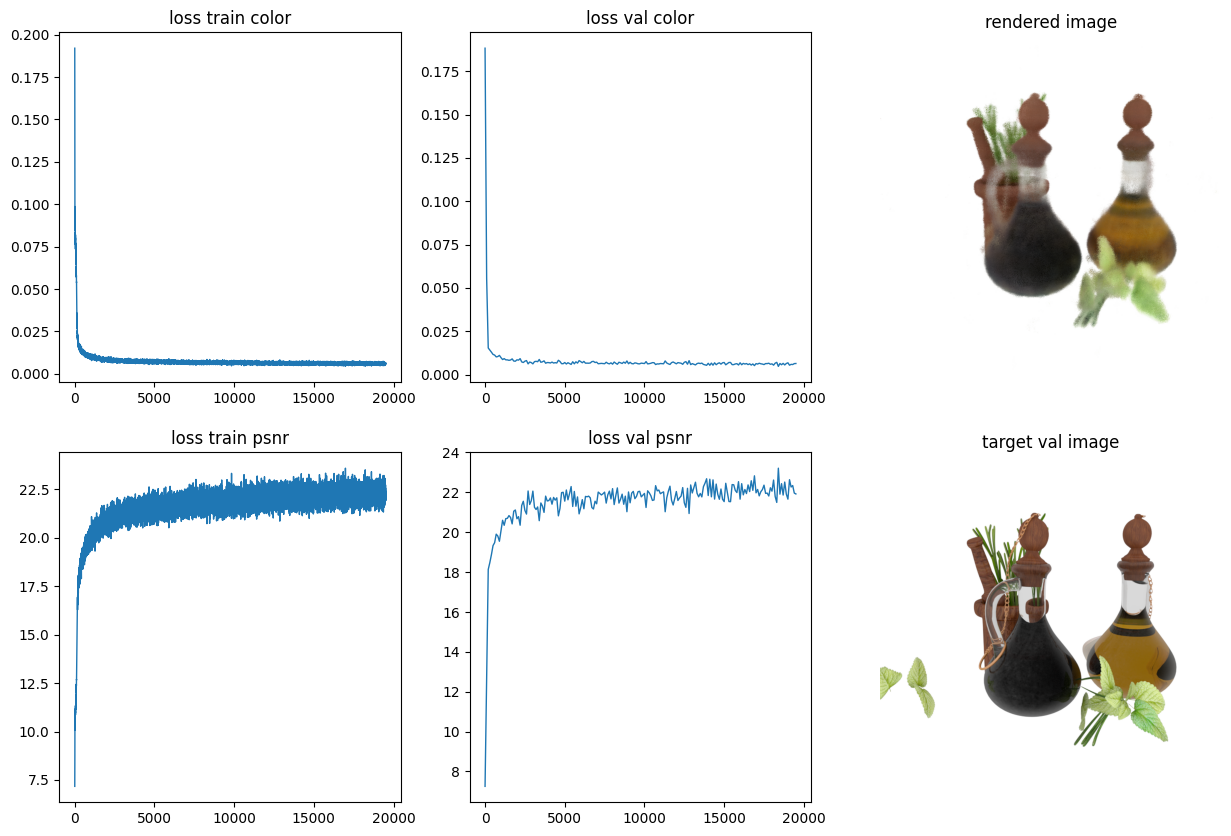

#####>Full size validation Iteration 19500.00: loss color = 6.47e-03 psnr = 2.19e+01
Iteration 19520.00: loss color = 4.98e-03 psnr = 2.30e+01
Iteration 19540.00: loss color = 6.19e-03 psnr = 2.21e+01
Iteration 19560.00: loss color = 6.33e-03 psnr = 2.20e+01
Iteration 19580.00: loss color = 5.91e-03 psnr = 2.23e+01
======>Validation Iteration 19600.00: loss color = 5.78e-03 psnr = 2.24e+01
Iteration 19600.00: loss color = 5.78e-03 psnr = 2.24e+01
Iteration 19620.00: loss color = 5.73e-03 psnr = 2.24e+01
Iteration 19640.00: loss color = 6.30e-03 psnr = 2.20e+01
Iteration 19660.00: loss color = 6.38e-03 psnr = 2.19e+01
Iteration 19680.00: loss color = 5.39e-03 psnr = 2.27e+01
======>Validation Iteration 19700.00: loss color = 6.37e-03 psnr = 2.20e+01
Iteration 19700.00: loss color = 6.37e-03 psnr = 2.20e+01
Iteration 19720.00: loss color = 5.01e-03 psnr = 2.30e+01
Iteration 19740.00: loss color = 6.88e-03 psnr = 2.16e+01
Iteration 19760.00: loss color = 5.60e-03 psnr = 2.25e+01
Iteration

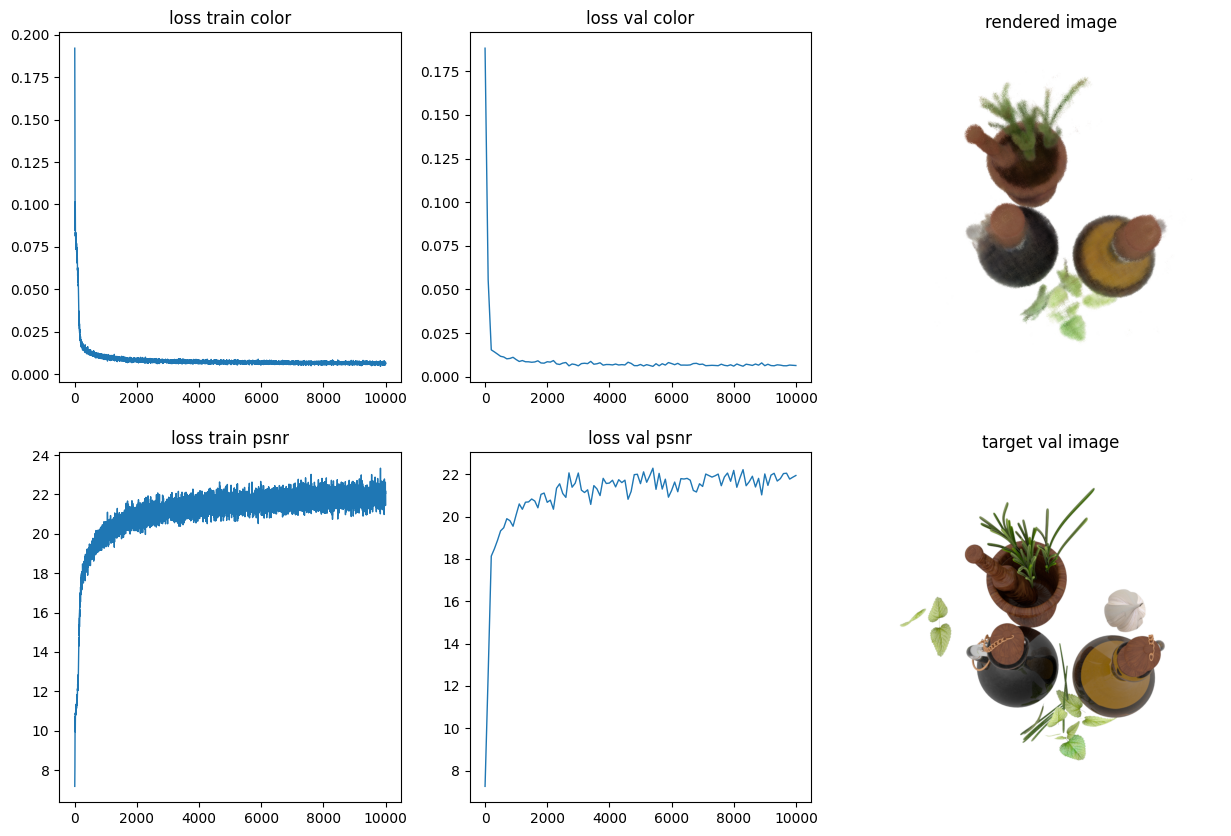

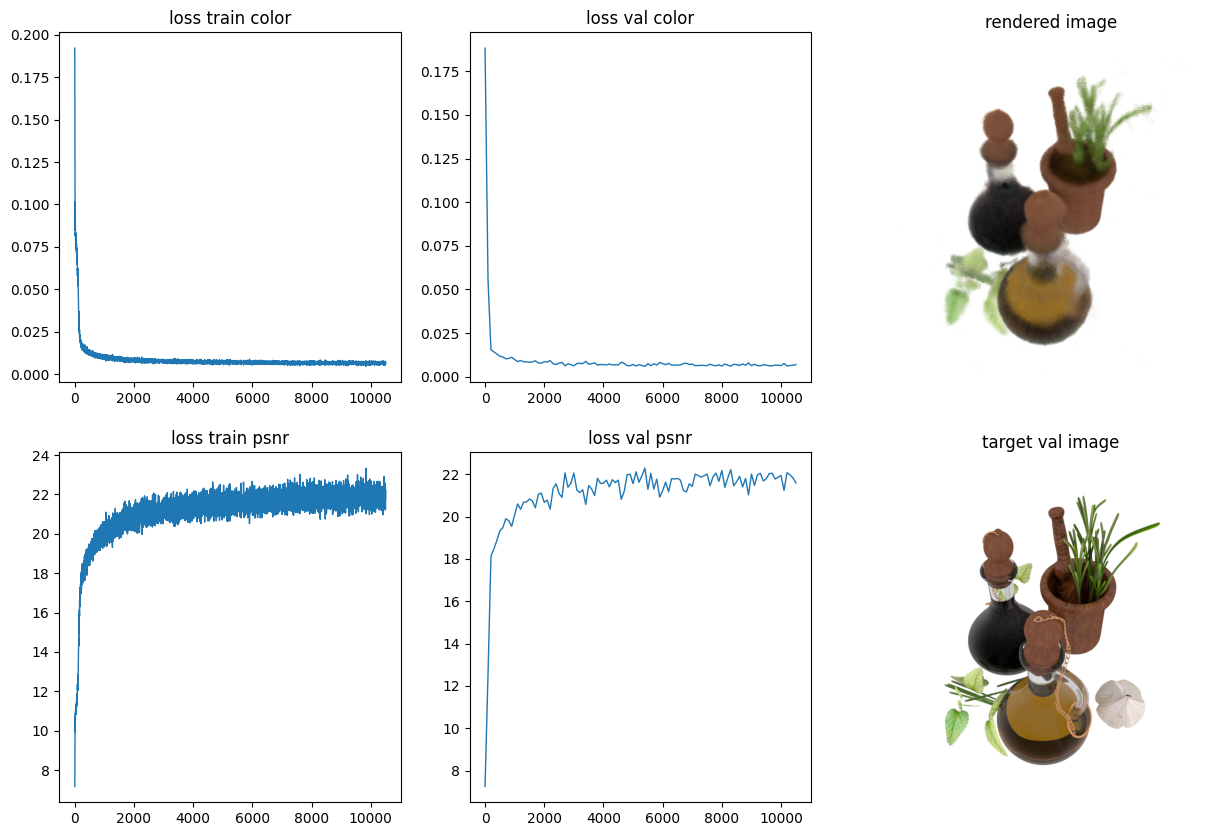

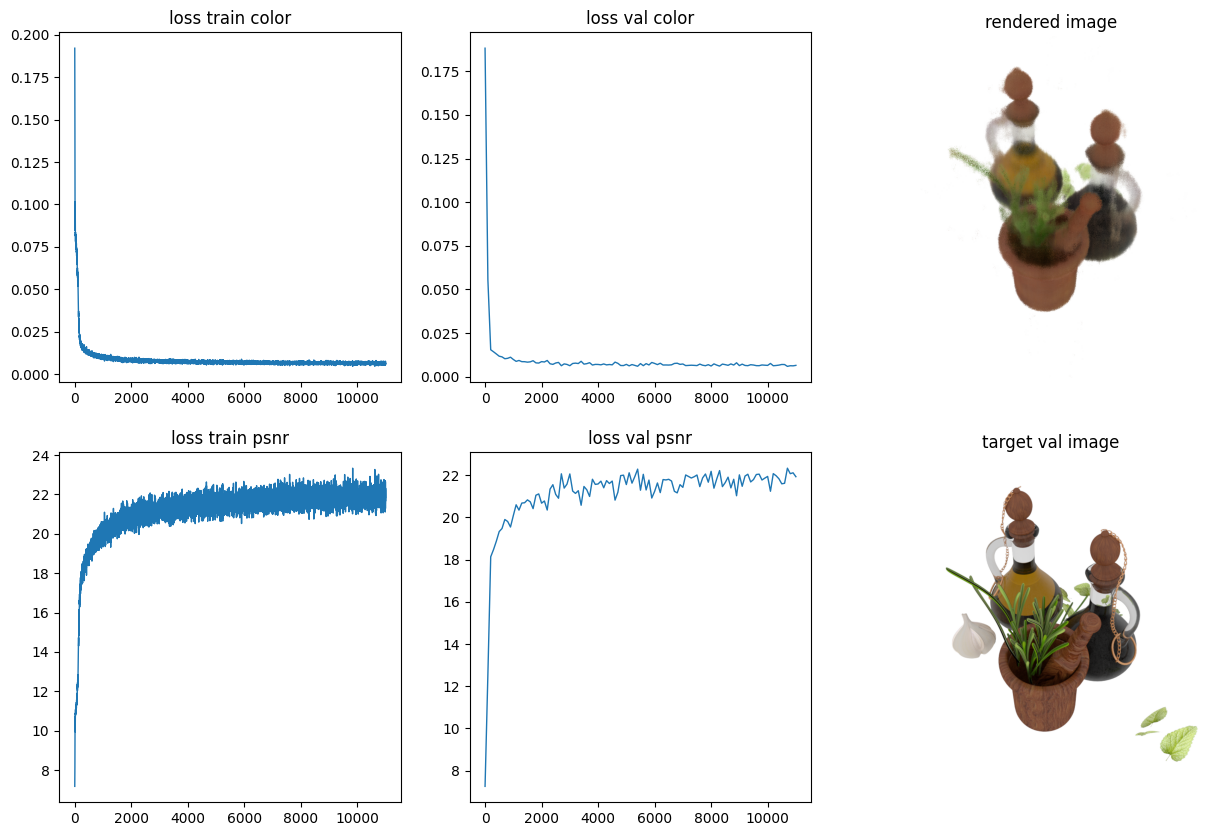

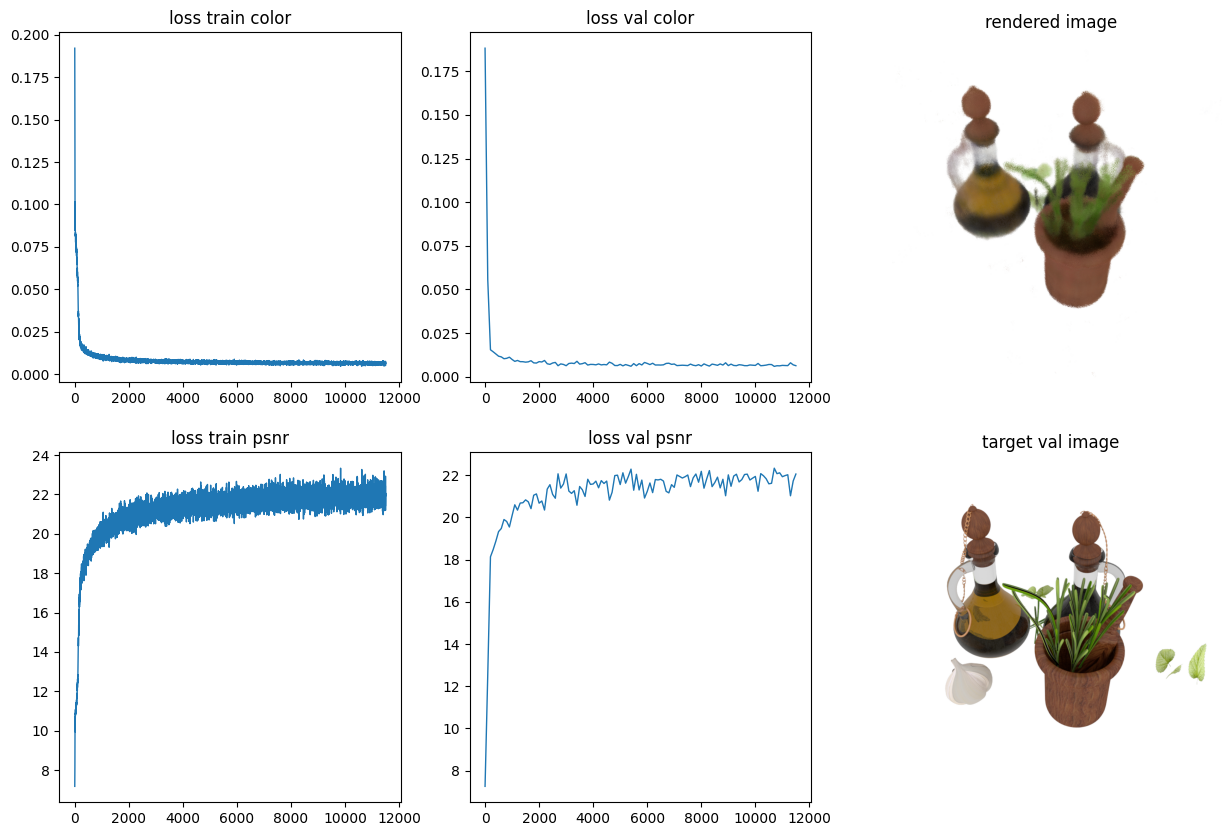

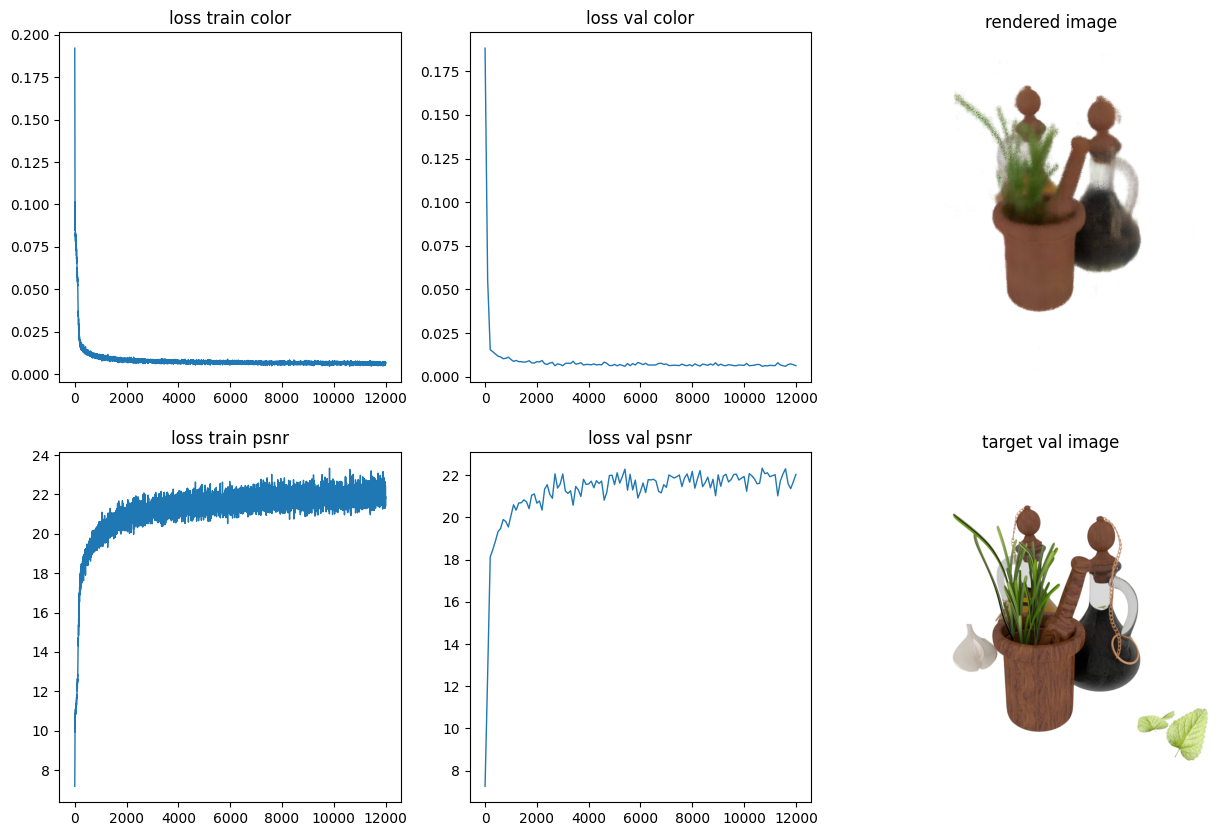

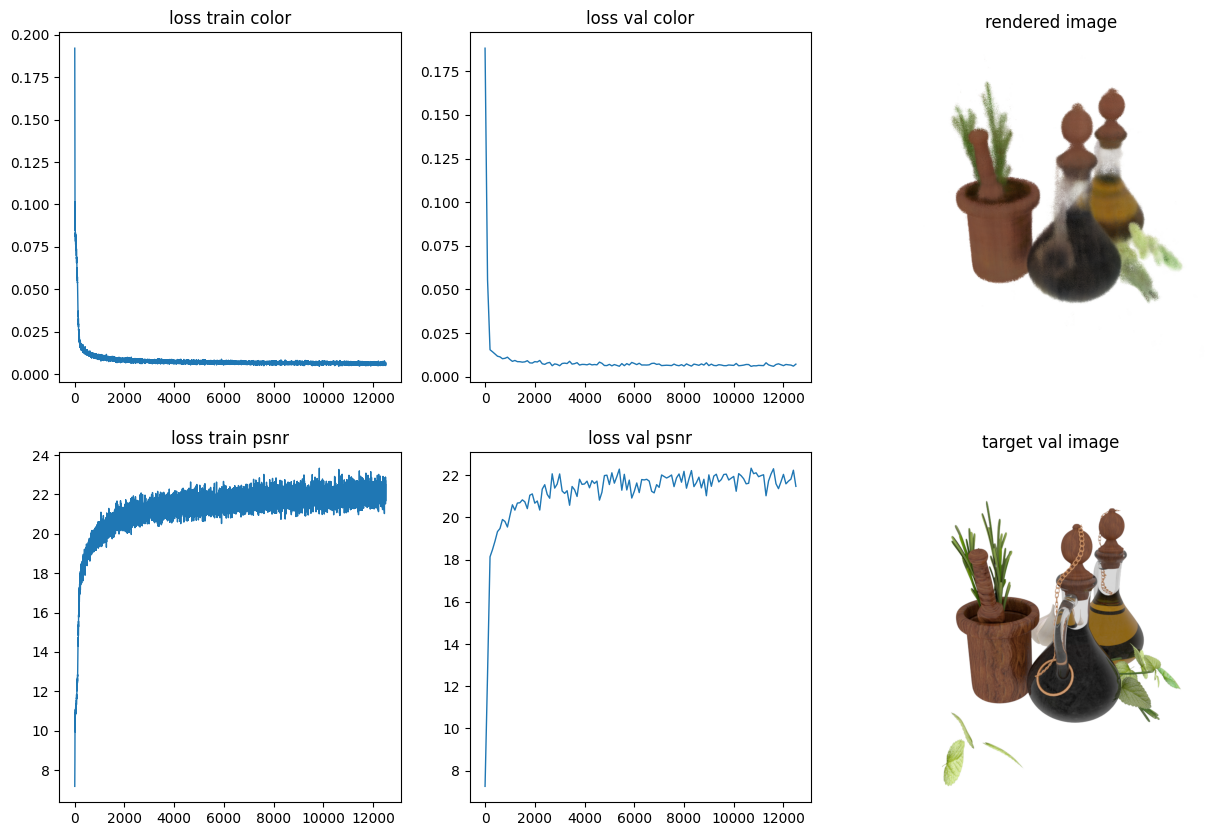

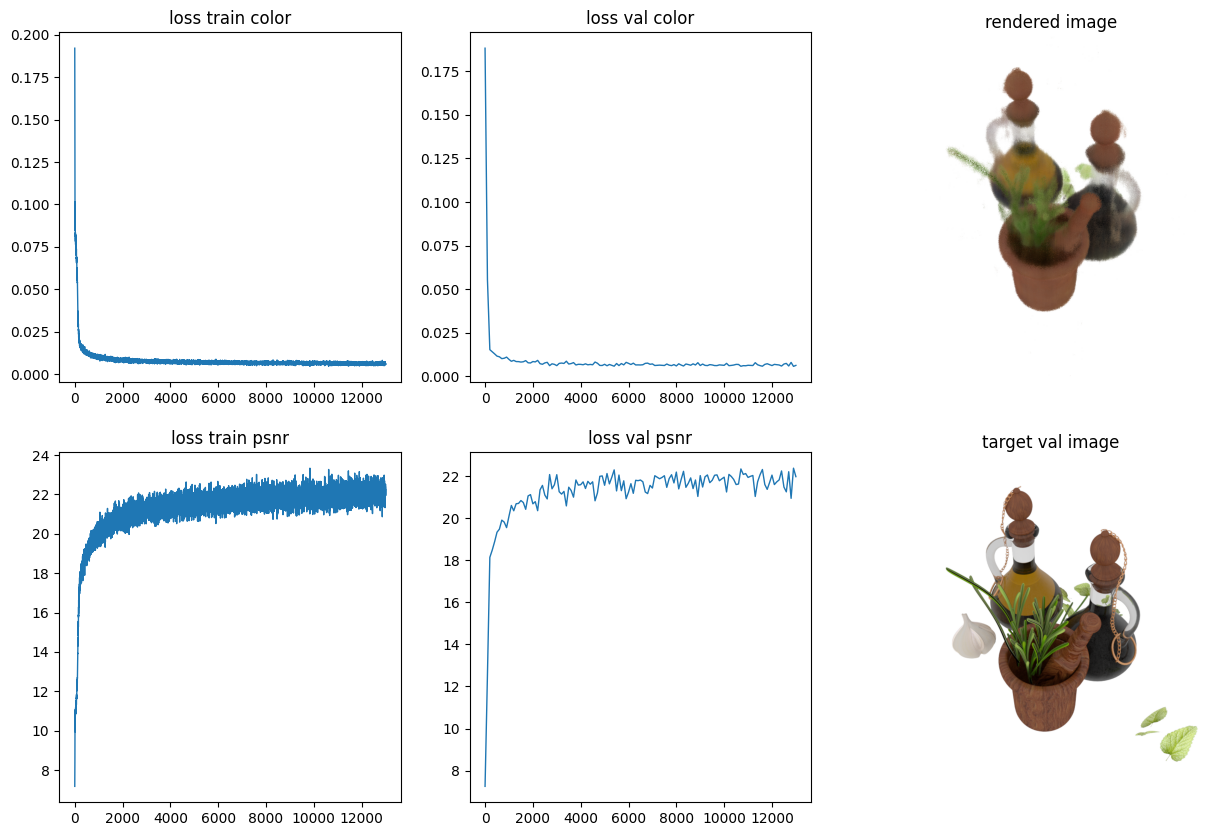

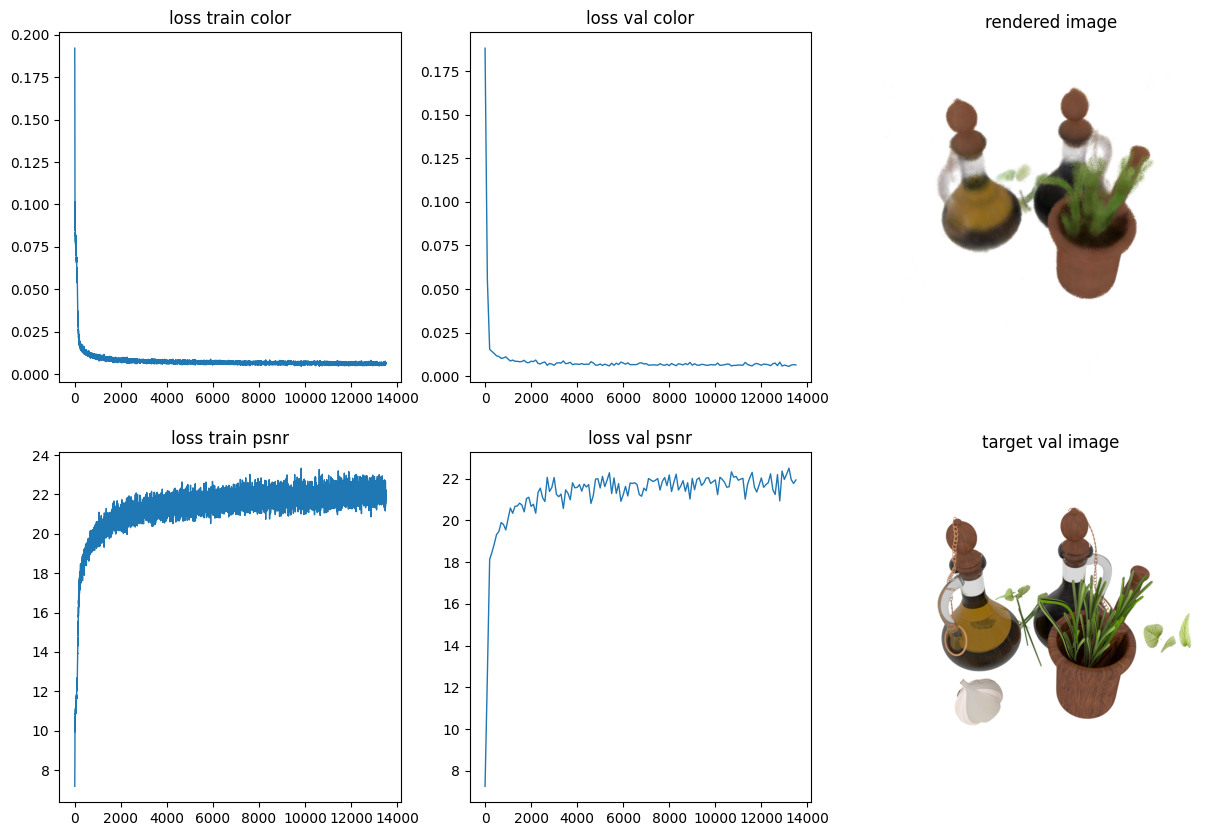

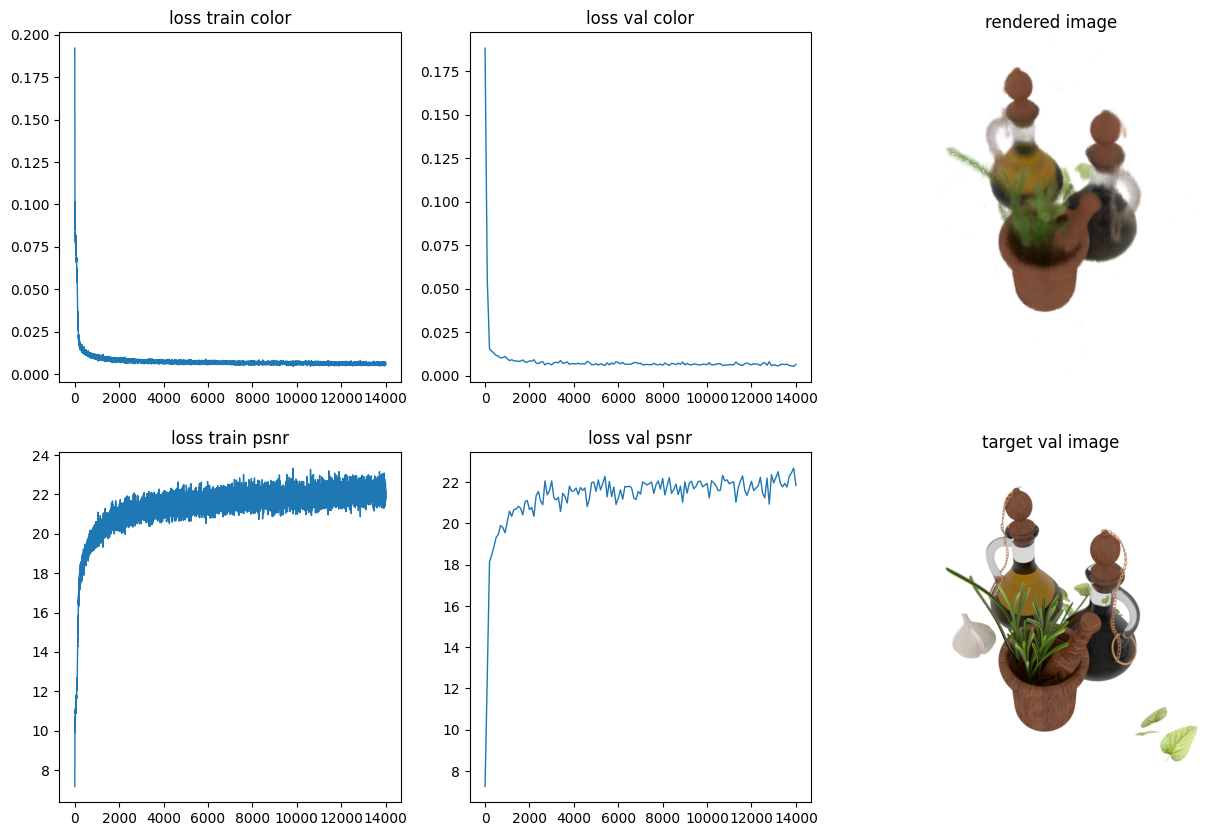

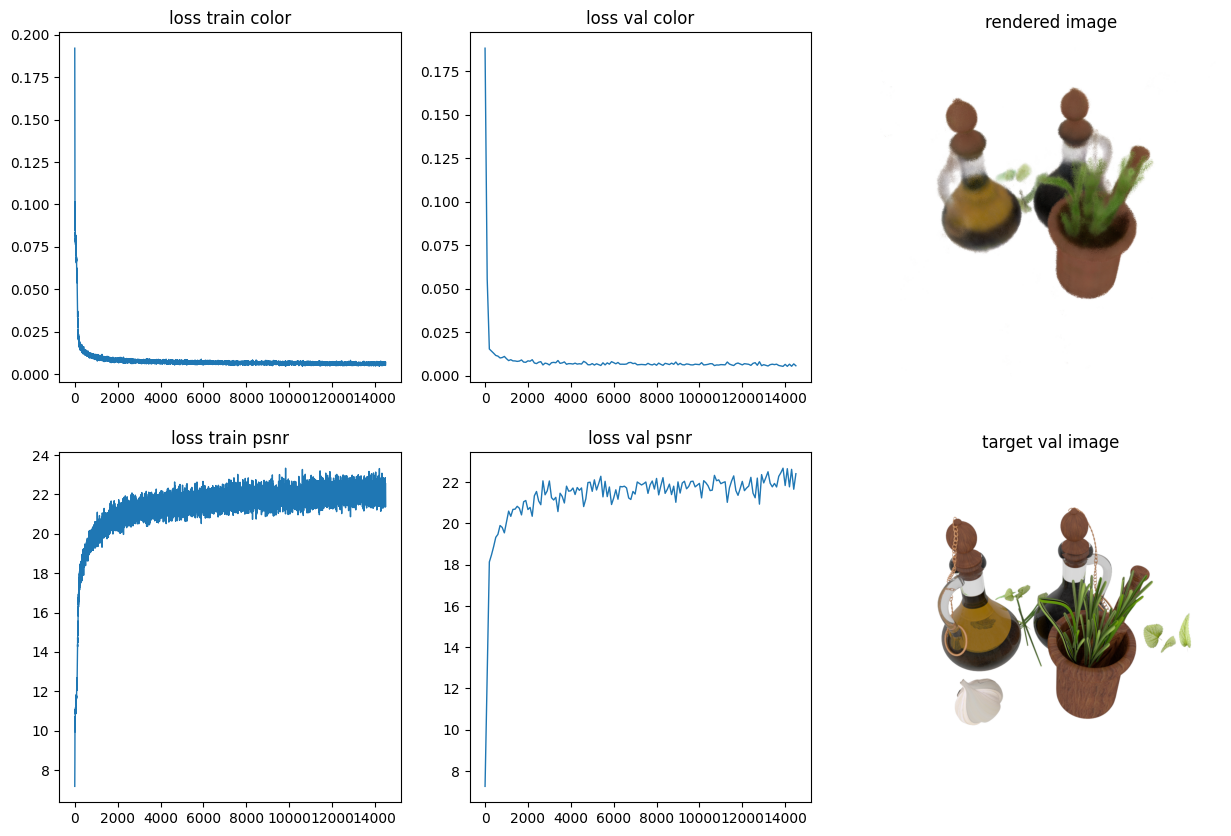

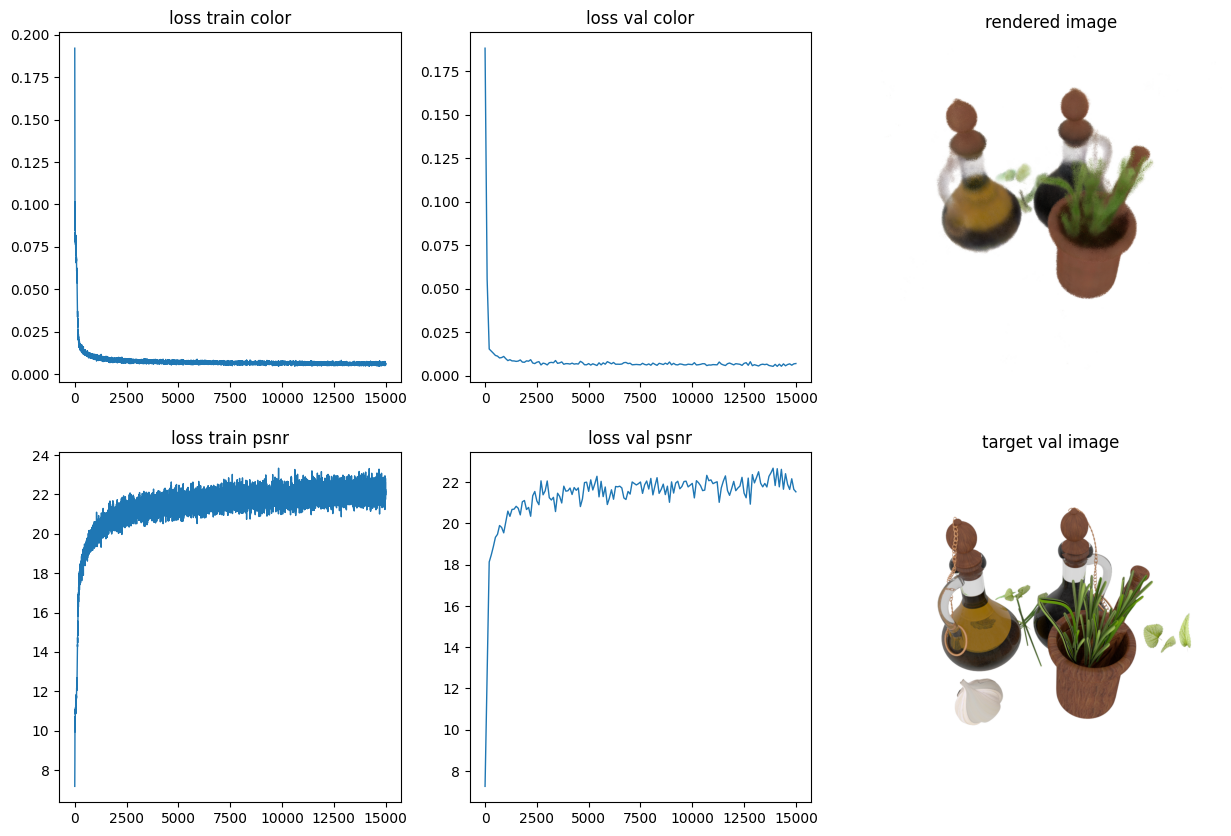

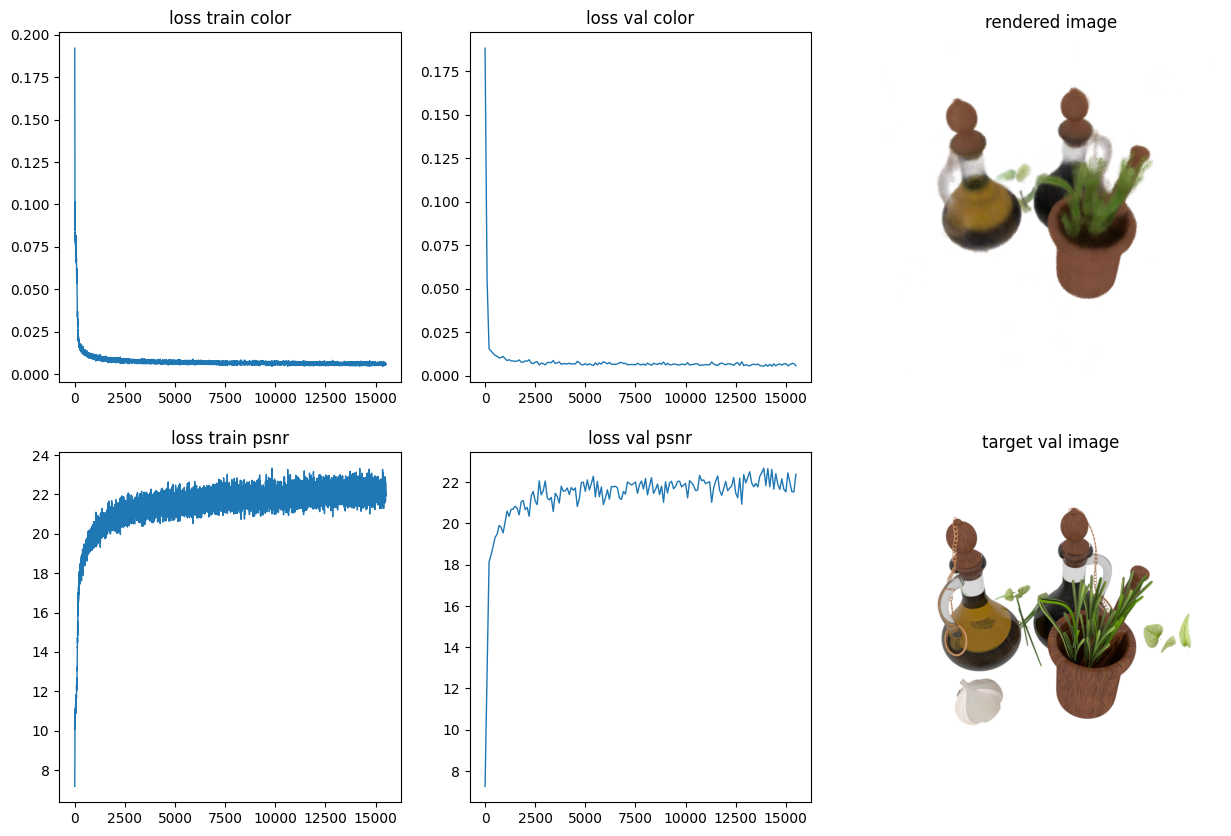

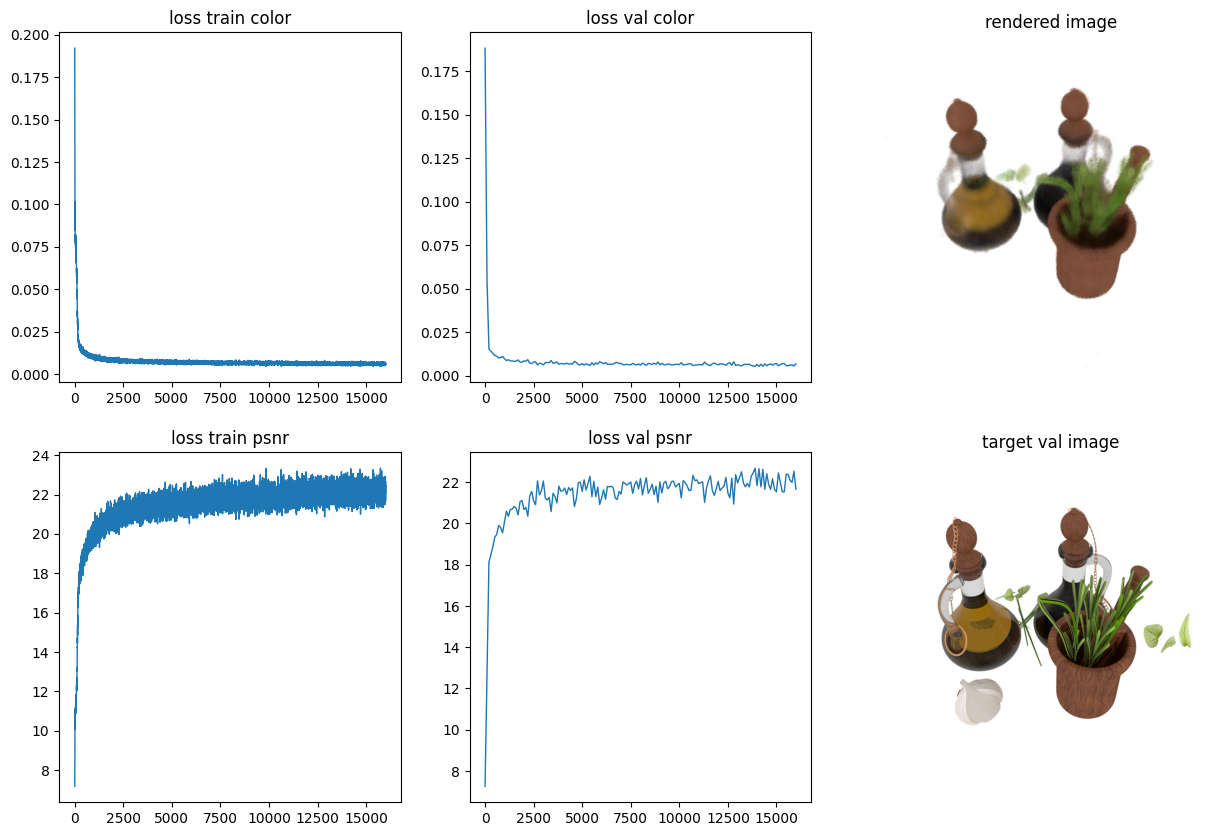

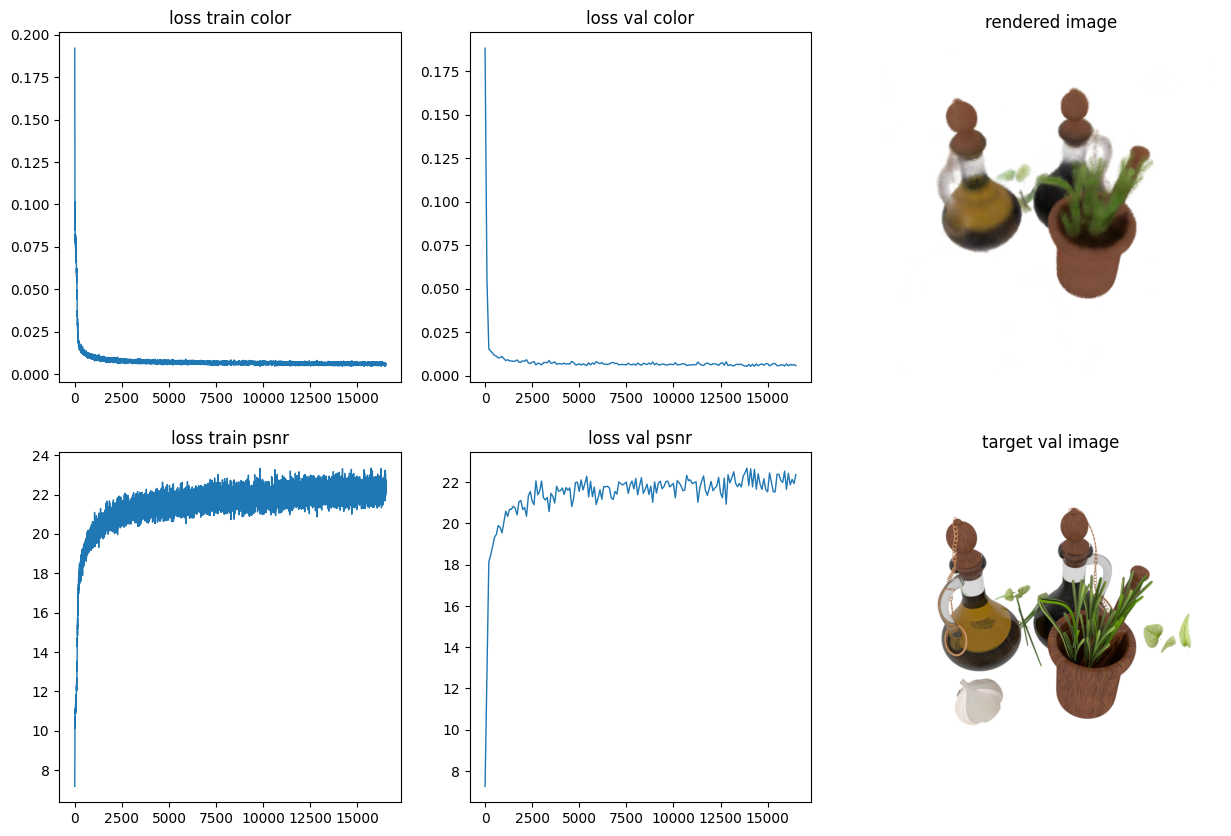

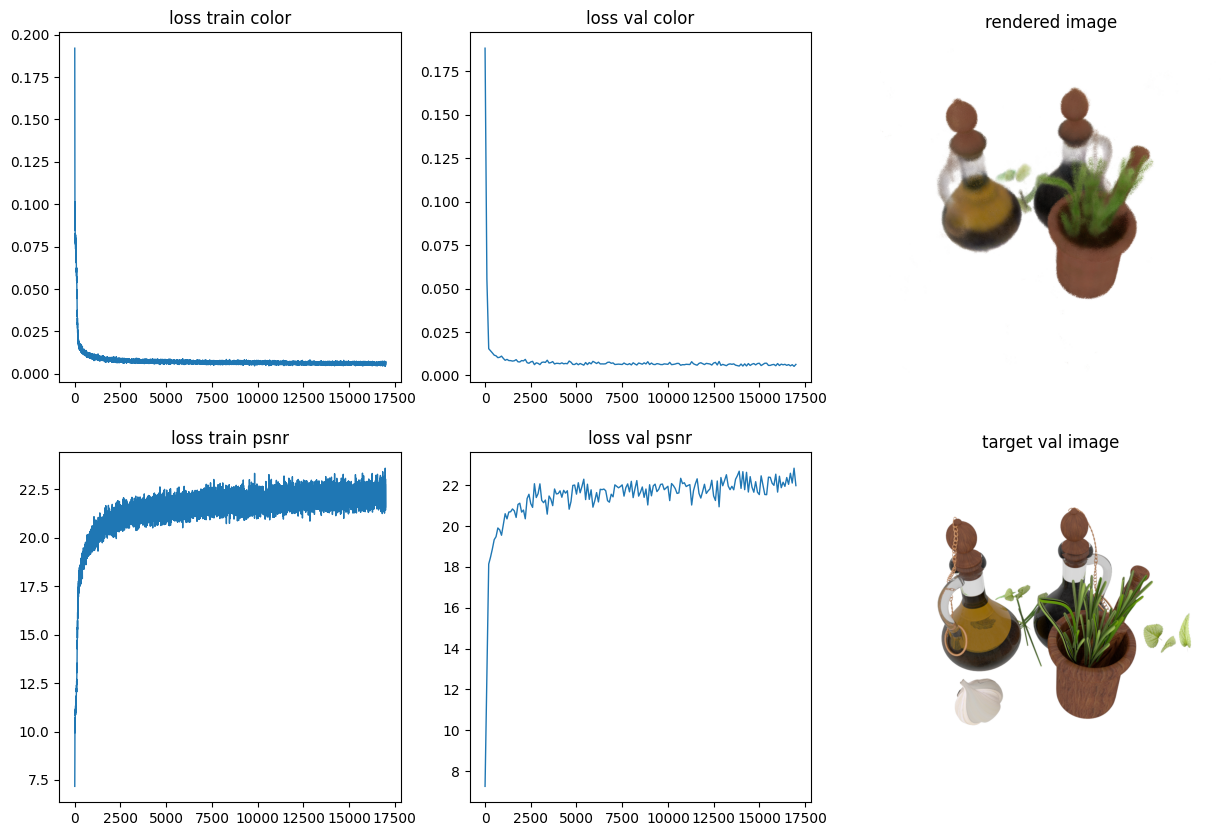

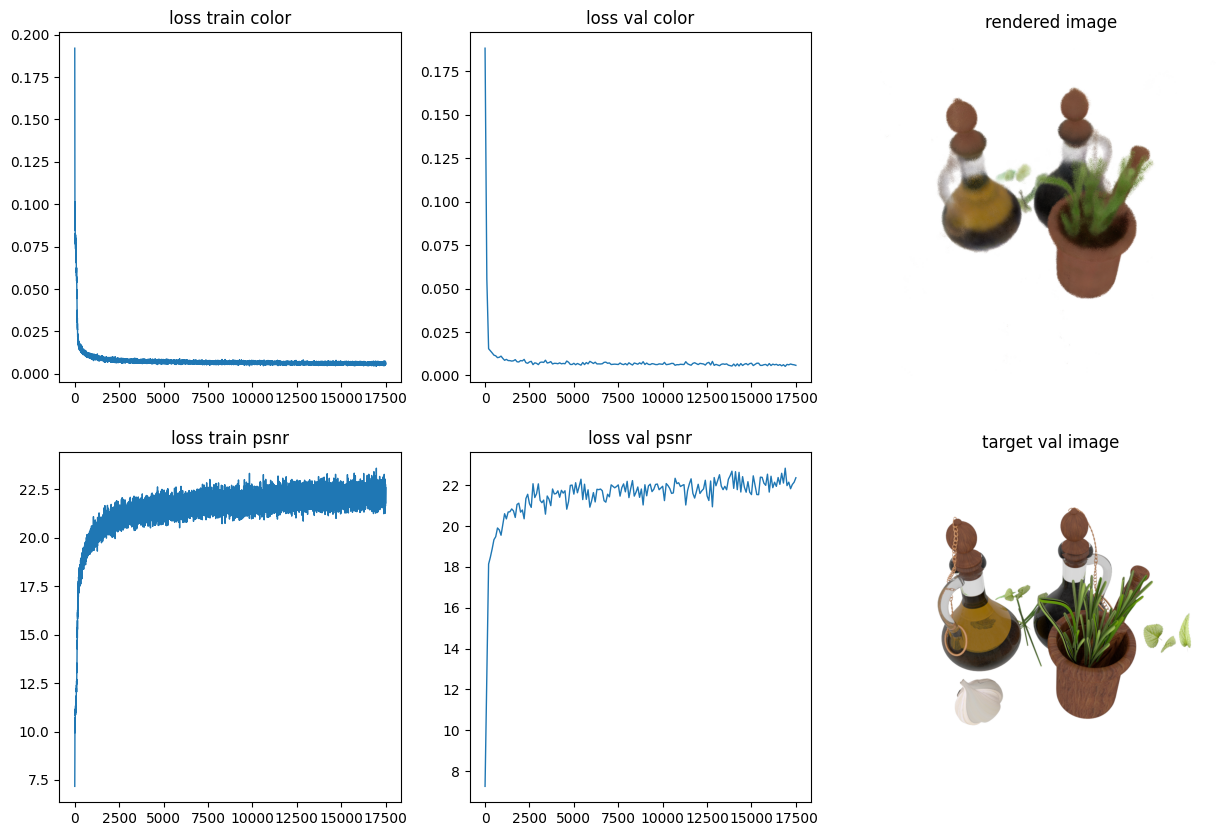

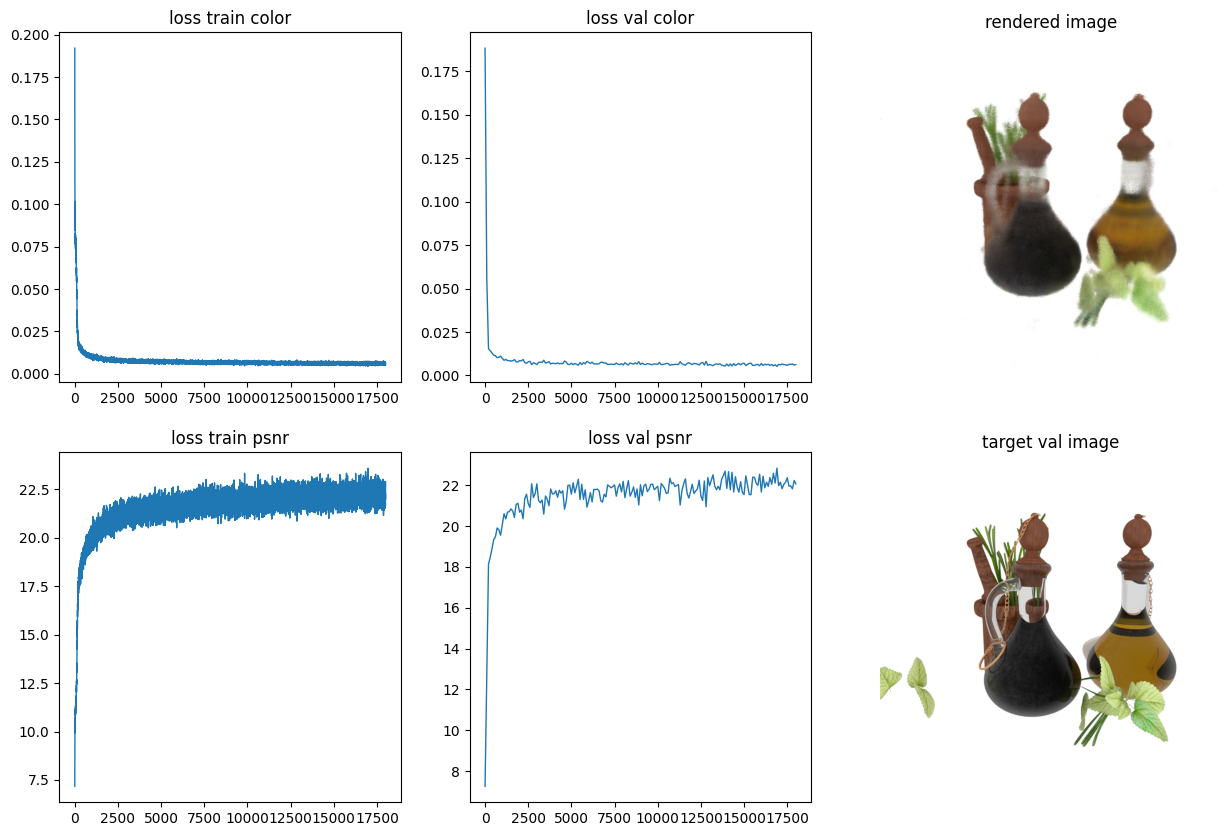

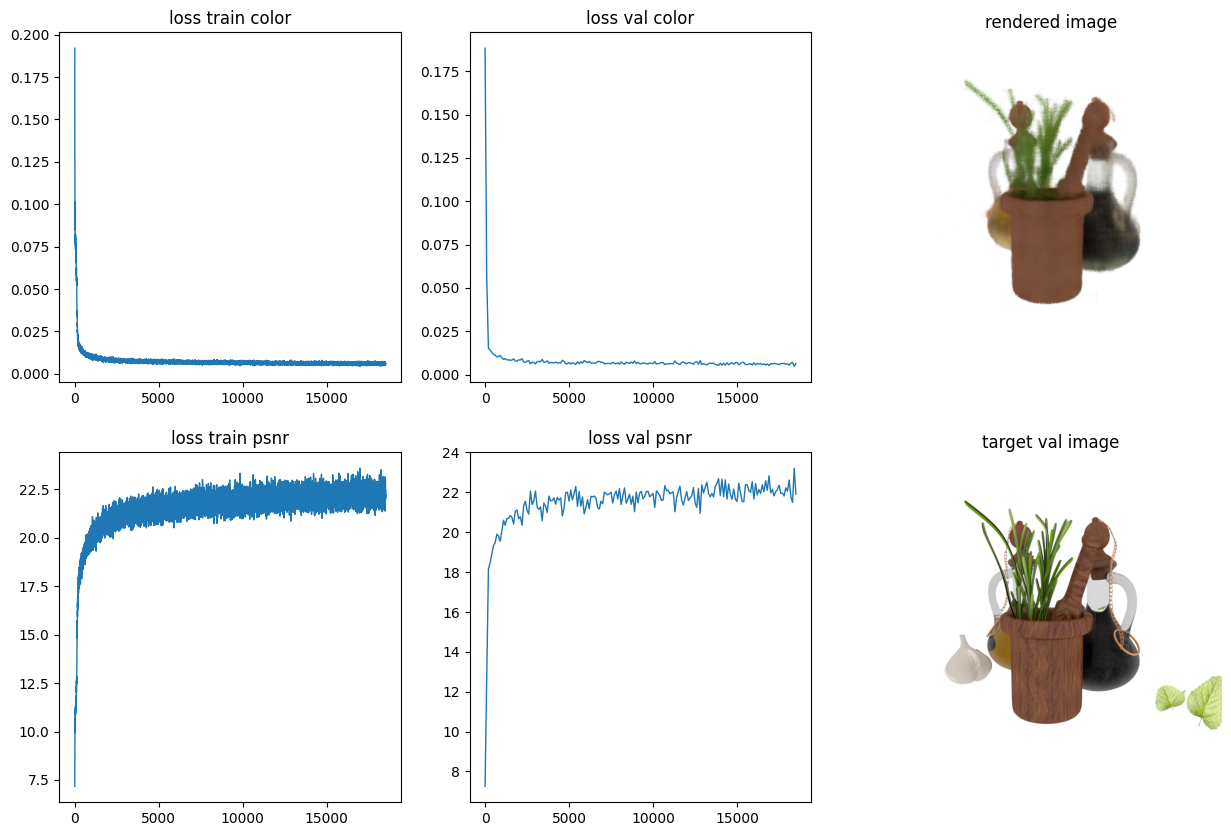

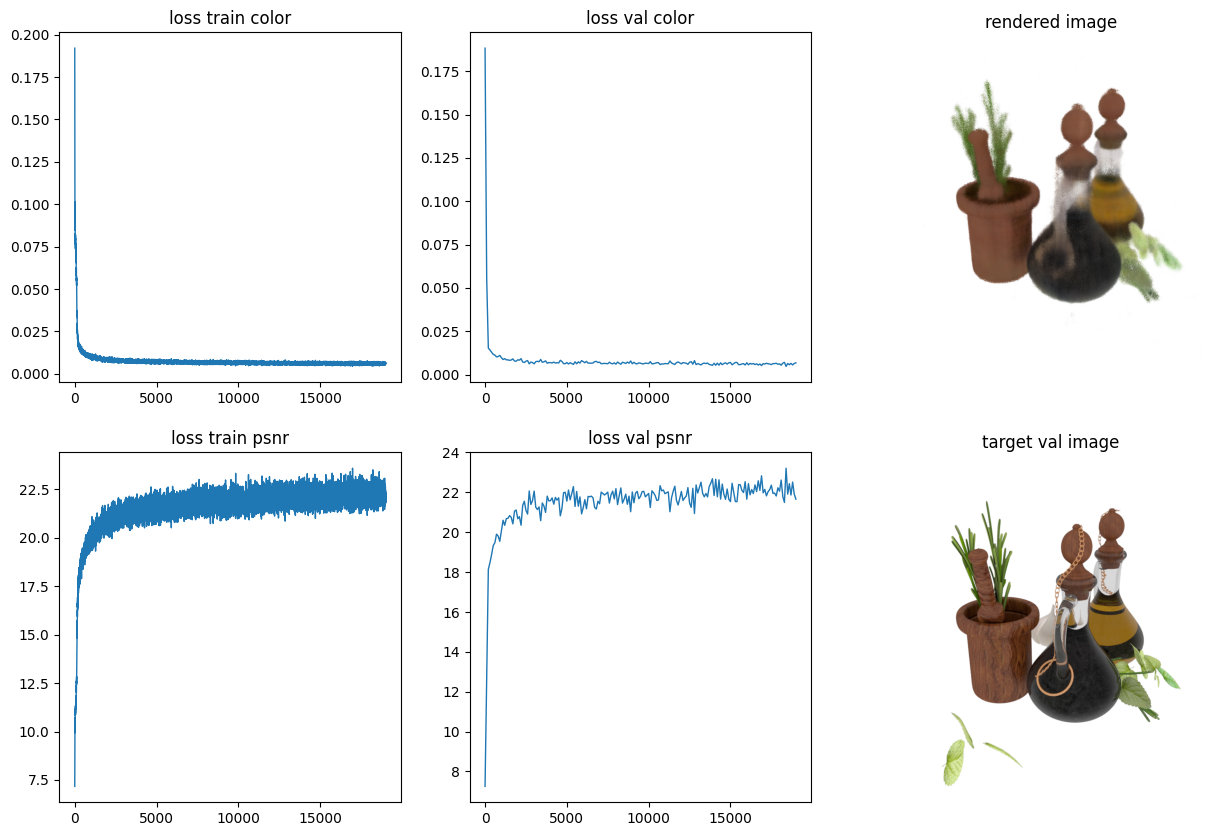

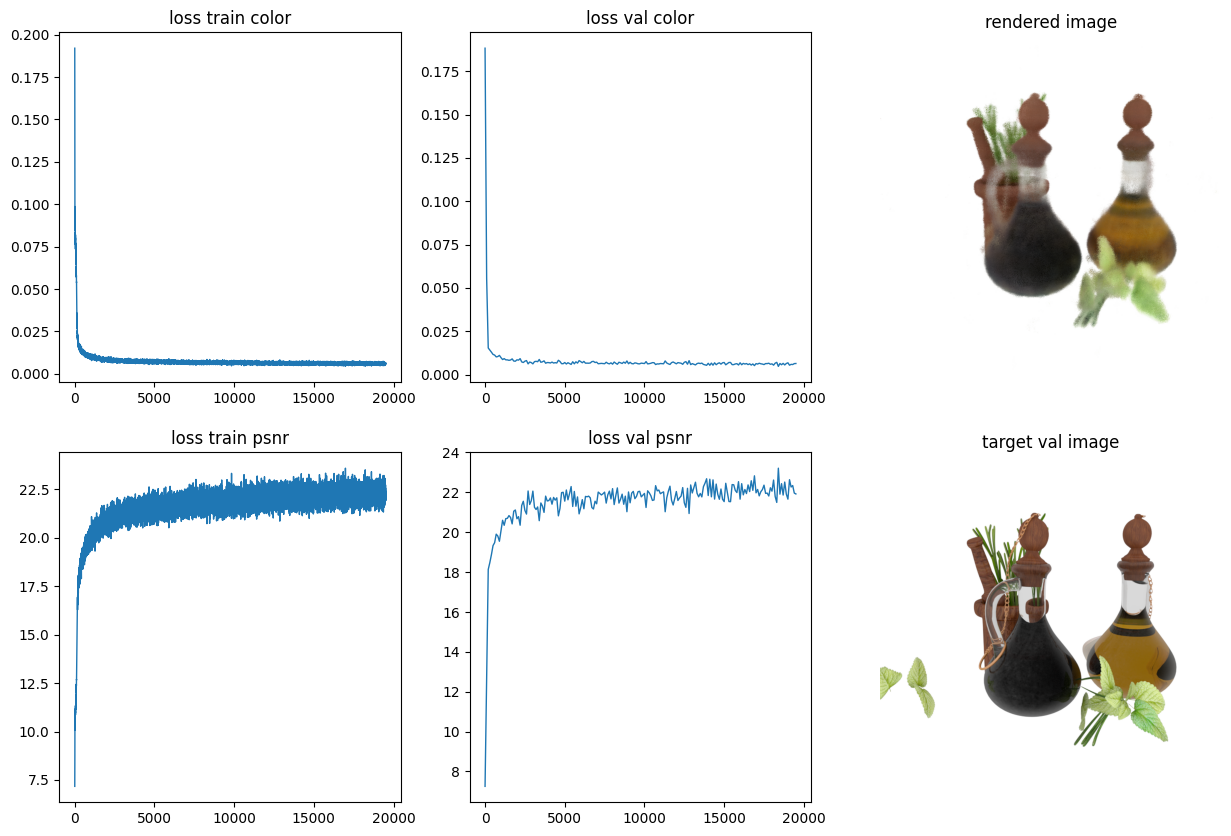

In [11]:
# Set the seed for reproducibility
torch.manual_seed(1)

# Instantiate the radiance field model.
neural_radiance_field = NeuralRadianceField_torch(D = args['num_layers'],
                                            skips = args['skips'],
                                            n_harmonic_functions_pos = args['n_harmonic_functions_pos'],
                                           n_harmonic_functions_dir = args['n_harmonic_functions_dir']).to(device)

if args['coarse_fn_path'] is not None and args['init_fine_fn']:
    neural_radiance_field.load_state_dict(torch.load(args['coarse_fn_path'])['model_state_dict'])

if args['coarse_fn_path'] is not None:
    # Load the coarse model
    coarse_nerf = NeuralRadianceField_torch(D = args['num_layers'],
                                                skips = args['skips'],
                                                n_harmonic_functions_pos = args['n_harmonic_functions_pos'],
                                            n_harmonic_functions_dir = args['n_harmonic_functions_dir']).to(device)

    coarse_nerf.load_state_dict(torch.load(args['coarse_fn_path'])['model_state_dict'])
    loss, psnr, _, _, _, _ = get_loss_psnr(val_rays_rgb, coarse_nerf, None, True)
    print('coarse_model_loaded: loss and psnr: ', loss, psnr)
else:
    coarse_nerf = None

# Optimizer
lr = args['learning_rate']
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)
optimizer.zero_grad(set_to_none=True)

# Init the loss history buffers.
train_loss_history_color, train_psnr_history = [], []
val_loss_history_color, val_psnr_history = [], []
best_50_val = 0

start_iter = 0

# Reload checkpoint
if args['checkpoint'] is not None:
    ckpt = torch.load(args['checkpoint'])
    start_iter = ckpt['iter']
    assert train_files == ckpt['train_files']
    neural_radiance_field.load_state_dict(ckpt['model_state_dict'])
    loss, psnr, _, _, _, _ = get_loss_psnr(val_rays_rgb, neural_radiance_field, coarse_nerf, True)
    print('===ckpt loaded===: loss and psnr: ', loss, psnr)
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    for i, vals in enumerate(zip(ckpt['train_loss_history_color'], ckpt['train_psnr_history'])):
        log_stuff(*vals, train_loss_history_color, train_psnr_history, 'train', i)
    for i, vals in enumerate(zip(ckpt['val_loss_history_color'], ckpt['val_psnr_history'])):
        log_stuff(*vals, val_loss_history_color, val_psnr_history, 'val', i*val_freq)

i_batch = 0
for iteration in range(start_iter, args['num_iterations']):      
    
    # Exponential decay
    if iteration <= round(0.75*args['num_iterations']):
        new_lrate = lr * (0.1 ** (iteration / round(0.75*args['num_iterations'])))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
            
        
    # run train loop and log values
    loss, psnr, train_rays_rgb, i_batch, _, _ = get_loss_psnr(train_rays_rgb, neural_radiance_field, coarse_nerf, False, i_batch)
    log_stuff(loss, psnr, train_loss_history_color, train_psnr_history, 'train', iteration)
    
    # Take the optimization step, but scale the loss appropriately firs
    loss /= args['accum_iter']
    loss.backward()
    
    # weights update with gradient accumulation
    if ((iteration + 1) % args['accum_iter'] == 0) or (iteration + 1 == args['num_iterations']):
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
    if iteration % val_freq == 0:
        # run val loop and log values
        loss, psnr, _, _, _, _ = get_loss_psnr(val_rays_rgb, neural_radiance_field, coarse_nerf, True)
        log_stuff(loss, psnr, val_loss_history_color, val_psnr_history, 'val', iteration)
        print(f"======>Validation Iteration {iteration/args['accum_iter']:08.2f}: loss color = {float(loss):1.2e} psnr = {float(psnr):1.2e}")

    # Every 20 iterations, print the current values of the losses
    if iteration % 20 == 0:
        print(f"Iteration {iteration/args['accum_iter'] :08.2f}: loss color = {float(loss):1.2e} psnr = {float(psnr):1.2e}")
        
    # # Every 100 iterations save model
    if (iteration+1) % (100*args['accum_iter']) == 0:
        torch.save({
            'iter': iteration,
            'train_files': train_files,
            'model_state_dict': neural_radiance_field.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history_color': train_loss_history_color,
            'train_psnr_history': train_psnr_history,
            'val_loss_history_color': val_loss_history_color,
            'val_psnr_history': val_psnr_history,
            }, args['model_save_path'])
        if sum(val_psnr_history[-50:]) > best_50_val:
            print("Improvement in eval saving eval_up model!!")
            best_50_val = sum(val_psnr_history[-50:])
            torch.save({
                'iter': iteration,
                'train_files': train_files,
                'model_state_dict': neural_radiance_field.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss_history_color': train_loss_history_color,
                'train_psnr_history': train_psnr_history,
                'val_loss_history_color': val_loss_history_color,
                'val_psnr_history': val_psnr_history,
                }, args['eval_up_model_save_path'])
    
    # Visualize the full renders
    if iteration % viz_freq == 0:
        params = train_rays_rgb if viz_train else val_rays_rgb
        fig, loss, psnr = show_full_render(neural_radiance_field, coarse_nerf, device, params, 
                           train_loss_history_color, train_psnr_history, val_loss_history_color, val_psnr_history)
        log_stuff(loss, psnr, [], [], 'Full_size_val', iteration)
        print(f"#####>Full size validation Iteration {iteration/args['accum_iter']:08.2f}: loss color = {float(loss):1.2e} psnr = {float(psnr):1.2e}")
        fig 

In [12]:
mlflow.end_run()

In [13]:
# useful posts, @273: 5k, 100x100, 23 psnr(100), good visualization, 
# @267 40k 26 psnr,
# @271, visualization of results train: 100 and results 800, 200k iterations